# Deterministic Case 

Consider the following reinforcement learning problem.


<figure>
<center>
<img src="https://drive.google.com/uc?export=view&id=1IDUkDGqQ1xSKOT3Wg8SKgAlKsDIdUQUy" width="250">
<figcaption>Figure 1</figcaption></center>
</figure>



*   There are 12 states, and the actions are $\{ up, down, left, right \}$. Legal actions are those that go to the immediate neighbor, horizontally or vertically (but not diagonally). State $S_8$ is the goal state, and all actions here lead back to itself with reward 0.

*   The rewards for all action are 0, except for all actions that lead into $s_8$, which are 100 (as shown in the figure).

*   In all cases, assume $\gamma = 0.9$.

* Initially, all $Q(s,a) = 0$.


## Simple discrete, deterministic Q-learning 

In [3]:
#!/usr/bin/python

# qlearn.py : simple discrete, deterministic Q-learning 
#
# Requires: numpy, pandas, matplotlib

import numpy as np
import pandas as pd
import random 
import argparse, sys
import matplotlib.pyplot as plt

#--------------------
# config (more config below : search for "modify" 
#
# - for colab, etc, use the "notebook" mode
#--------------------

# mode="console"
mode="notebook" 

#--------------------
# console mode: process command line arguments
#--------------------
def parse_args():

  cmd = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
  cmd.add_argument('--alpha', type=float, default="1.0", help="mixing rate")
  cmd.add_argument('--gamma', type=float, default="0.9", help="discount rate")
  cmd.add_argument('--epsilon', type=float, default="0.5", help="discount rate")
  cmd.add_argument('--num_iter', type=int, default="300", help="number of iterations to run")
  cmd.add_argument('--run_avg_rate', type=float, default="0.95", help="number of iterations to run")
  cmd.add_argument('--display_flag', type=str, default="True", help="display Q table after each iteration?")

  return cmd.parse_args()

#--------------------
# notebook mode: process command line arguments
#--------------------
class argclass:

  def __init__(self):

    self.alpha = 1.0
    self.gamma = 0.9
    self.epsilon = 0.5
    self.num_iter = 1000
    self.run_avg_rate = 0.95
    self.display_flag = "True"

#--------------------
# select mode 
#--------------------
if (mode=="console"):

  args = parse_args()

elif (mode=="notebook"):

  args = argclass()

else:

  print("Invalid mode: check the config")
  exit()

#--------------------
# find sum of abs difference in the two table values
#--------------------
def df_diff(df1, df2):

  d = df1-df2
  return d.abs().to_numpy().sum() 

#----------------------------------------------------------------------------
#
# Environment set up : modify this part to change the environment
#
#----------------------------------------------------------------------------

#--------------------
# state index : modify
#
# layout =  (*) marks the goal. 
# 
# s0 s1 (s2)
# s3 s4 s5 
# 
#   * (s1,right) and (s5,up) has reward 100, all others are 0.
#   * All actions in s2 lead back to s2, with reward 0.
#
#--------------------
s_index = ["s0", "s1", "s2", "s3", "s4", "s5", "s6","s7","s8","s9","s10","s11"] 

#--------------------
# state transition table : modify 
#--------------------
delta = pd.DataFrame(
	{ 
	  "up"   : pd.Series(np.array([-1,-1, -1, 0, 1, 2, 3, 4, 8, 6, 7, 8]),index=s_index),
	  "down" : pd.Series(np.array([ 3, 4, 5,6,7,8,9,10,8,-1,-1,-1]),index=s_index),
	  "left" : pd.Series(np.array([-1, 0, 1,-1, 3, 4, -1,6,8,-1,9,10]),index=s_index),
	  "right": pd.Series(np.array([ 1, 2, -1, 4, 5,-1, 7, 8, 8, 10, 11, -1]),index=s_index)
	}
)

#--------------------
# reward table : modify
#--------------------
reward = pd.DataFrame(
	{ 
	  "up"   : pd.Series(np.array([-1, -1,  -1,  0,  0,0,0,0,0,0,0,100]),index=s_index),
	  "down" : pd.Series(np.array([ 0,  0,  0, 0, 0, 100,0,0,0,-1,-1,-1]),index=s_index),
	  "left" : pd.Series(np.array([-1,  0,  0, -1,  0,  0,-1,0,0,-1,0,0]),index=s_index),
	  "right": pd.Series(np.array([ 0,0,  -1,  0,  0, -1,0,100,0,0,0,-1]),index=s_index)
	}
)

print("\n\nDelta")
print(delta)

print("\n\nReward")
print(reward)

#--------------------
# goal state : modify
#--------------------
goal = 8

#----------------------------------------------------------------------------
#
# Main algorithm : no need to modify much below here (for the deterministic case)
#
#----------------------------------------------------------------------------

def qlearn_n(): 

  # extract number of states
  num_states = len(s_index)
  num_actions = 4
  
  # set up (s,a) visit count
  visits = (delta>=0).astype(int)-1
  
  run_avg = 0
  
  #--------------------
  # (1) Initialize Q table to zeros (-1 for invalid actions)
  #
  # - Reuse delta table to filter out invalid moves and set others to zero
  #--------------------
 
  Q=(delta>=0).astype(float)-1 

  old_Q = Q.copy(deep=True) 
  
  print("\n\nQ: initial")
  print(Q)
  
  #--------------------
  # (2) Main loop
  #--------------------
  
  d = np.zeros(args.num_iter)
  
  for n in range(args.num_iter):
    
    #----------
    # 1. s : randomly select state   
    #----------
  
    s = random.randint(0,num_states-1)
  
    while (s==goal): # avoid goal state
      s = random.randint(0,num_states-1)
      
    #----------
    # 2. a : choose action (epsilon greedy policy)
    #----------
  
    if (random.random() < (1-args.epsilon)):
  
      # greedy action:
      a = Q.iloc[s,:].argmax()
  
    else:
  
      # random action
      a = random.randint(0,num_actions-1)
  
      while (delta.iloc[s,a]==-1): # avoid invalid action
        a = random.randint(0,num_actions-1)
  
    #----------
    # 3. train
    #----------
  
    visits.iloc[s,a] = visits.iloc[s,a]+1

    alpha = args.alpha
    gamma = args.gamma
  
    # 3.1 find next state from (s,a)
  
    s_next = delta.iloc[s,a]
  
    # 3.2 update Q
  
    # Equation is: Q(s,a) = (1-alpha) x Q(s,a) + alpha*( r(s,a) + gamma * max_a' Q(s',a') )
    Q.iloc[s,a] = (1.0-alpha)*Q.iloc[s,a] + alpha*(reward.iloc[s,a] + gamma*Q.iloc[s_next,:].max())
  
  
    # 3.3 compute running average of the sum of Q(n) minus Q(n-1)
  
    d[n] = args.run_avg_rate * run_avg + (1-args.run_avg_rate) * df_diff(Q,old_Q)
    run_avg = d[n]
    old_Q = Q.copy(deep=True)
    
   


    # 3.3 print current Q and running average of Q diff.
  
    if (args.display_flag == "True"):
  
      print("\nQ : iter="+str(n))
      print(Q)
      print("diff = "+str(d[n]))

    if (n>50  and run_avg < 0.01):
 
        break

  #--------------------
  # (3) Print final Q table  and (s,a) visit count table
  #--------------------
  print("\nFinal Q table\n")
  print(Q)
  
  print("\nFinal visit count table\n")
  print(visits)
  '''
  #--------------------
  # (4) Plot diff Q(n), Q(n-1) running average
  #--------------------
  plt.title("Difference in Q table values over time: Running average, rate="+str(args.run_avg_rate))
  plt.xlabel("Iteration")
  plt.ylabel("Diff in Q table values")
  plt.plot(d)
  plt.show()
  '''

  print("diff in Q reached below 0.01 at iteration = "+str(n))

#-- end of qlearn() function def


args.display_flag = "False"  # Set this to "True" to see the changing Q table over time.
args.epsilon = 1.0
qlearn_n()

# after you run it, check if your Delta (state transition table) and the Reward table are accurate, compared to Figure 1.




Delta
     up  down  left  right
s0   -1     3    -1      1
s1   -1     4     0      2
s2   -1     5     1     -1
s3    0     6    -1      4
s4    1     7     3      5
s5    2     8     4     -1
s6    3     9    -1      7
s7    4    10     6      8
s8    8     8     8      8
s9    6    -1    -1     10
s10   7    -1     9     11
s11   8    -1    10     -1


Reward
      up  down  left  right
s0    -1     0    -1      0
s1    -1     0     0      0
s2    -1     0     0     -1
s3     0     0    -1      0
s4     0     0     0      0
s5     0   100     0     -1
s6     0     0    -1      0
s7     0     0     0    100
s8     0     0     0      0
s9     0    -1    -1      0
s10    0    -1     0      0
s11  100    -1     0     -1


Q: initial
      up  down  left  right
s0  -1.0   0.0  -1.0    0.0
s1  -1.0   0.0   0.0    0.0
s2  -1.0   0.0   0.0   -1.0
s3   0.0   0.0  -1.0    0.0
s4   0.0   0.0   0.0    0.0
s5   0.0   0.0   0.0   -1.0
s6   0.0   0.0  -1.0    0.0
s7   0.0   0.0   0.0    0.0
s8 

### $V^*(s)$ table

In [4]:
def optimal_V(): 

  # extract number of states
  num_states = len(s_index)
  num_actions = 4
  
  # set up (s,a) visit count
  visits = (delta>=0).astype(int)-1
  
  run_avg = 0

 
  Q=(delta>=0).astype(float)-1 

  old_Q = Q.copy(deep=True) 
  
  d = np.zeros(args.num_iter)
  
  for n in range(args.num_iter):
  
    s = random.randint(0,num_states-1)
  
    while (s==goal): # avoid goal state
      s = random.randint(0,num_states-1)

    if (random.random() < (1-args.epsilon)):
  
      # greedy action:
      a = Q.iloc[s,:].argmax()
  
    else:
  
      # random action
      a = random.randint(0,num_actions-1)
  
      while (delta.iloc[s,a]==-1): # avoid invalid action
        a = random.randint(0,num_actions-1)

    visits.iloc[s,a] = visits.iloc[s,a]+1

    alpha = args.alpha
    gamma = args.gamma
  

  
    s_next = delta.iloc[s,a]

    Q.iloc[s,a] = (1.0-alpha)*Q.iloc[s,a] + alpha*(reward.iloc[s,a] + gamma*Q.iloc[s_next,:].max())
  

  
    d[n] = args.run_avg_rate * run_avg + (1-args.run_avg_rate) * df_diff(Q,old_Q)
    run_avg = d[n]
    old_Q = Q.copy(deep=True)

    if (n>50  and run_avg < 0.01):
 
        break

  #--------------------
  # (5) V*(s)
  #--------------------
  V = Q.max(axis=1)
  V.to_frame()
  V = np.stack(V.values)
  V = V.reshape((4,3))
  df = pd.DataFrame(V, index=["","","",""], columns=["","",""])
  print("\n Optimal V table \n")
  print(df)

print("\n The optimal V values in layout of figure 1 is:\n")
optimal_V()




 The optimal V values in layout of figure 1 is:


 Optimal V table 

                    
  72.9   81.0   90.0
  81.0   90.0  100.0
  90.0  100.0    0.0
  81.0   90.0  100.0


### The running average of $\sum_{s,a \in S,A} | Q_{t+1}(s,a) - Q_t(s,a)|$ over the iterations

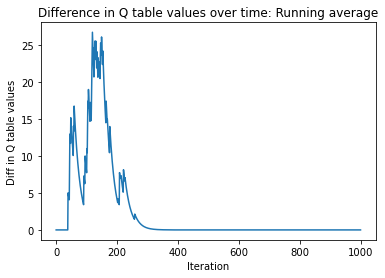

In [5]:
 def run_avg_plot(): 

  # extract number of states
  num_states = len(s_index)
  num_actions = 4
  
  # set up (s,a) visit count
  visits = (delta>=0).astype(int)-1
  
  run_avg = 0

 
  Q=(delta>=0).astype(float)-1 

  old_Q = Q.copy(deep=True) 
  
  d = np.zeros(args.num_iter)
  
  for n in range(args.num_iter):
  
    s = random.randint(0,num_states-1)
  
    while (s==goal): # avoid goal state
      s = random.randint(0,num_states-1)

    if (random.random() < (1-args.epsilon)):
  
      # greedy action:
      a = Q.iloc[s,:].argmax()
  
    else:
  
      # random action
      a = random.randint(0,num_actions-1)
  
      while (delta.iloc[s,a]==-1): # avoid invalid action
        a = random.randint(0,num_actions-1)

    visits.iloc[s,a] = visits.iloc[s,a]+1

    alpha = args.alpha
    gamma = args.gamma
  

  
    s_next = delta.iloc[s,a]

    Q.iloc[s,a] = (1.0-alpha)*Q.iloc[s,a] + alpha*(reward.iloc[s,a] + gamma*Q.iloc[s_next,:].max())
  

  
    d[n] = args.run_avg_rate * run_avg + (1-args.run_avg_rate) * df_diff(Q,old_Q)
    run_avg = d[n]
    old_Q = Q.copy(deep=True)

    if (n>50  and run_avg < 0.01):
 
        break
  #--------------------
  # (4) Plot diff Q(n), Q(n-1) running average
  #--------------------
  plt.title("Difference in Q table values over time: Running average")
  plt.xlabel("Iteration")
  plt.ylabel("Diff in Q table values")
  plt.plot(d)
  plt.show()

args.epsilon = 1.0
run_avg_plot()


## SARSA($\lambda$)



Delta
     up  down  left  right
s0   -1     3    -1      1
s1   -1     4     0      2
s2   -1     5     1     -1
s3    0     6    -1      4
s4    1     7     3      5
s5    2     8     4     -1
s6    3     9    -1      7
s7    4    10     6      8
s8    8     8     8      8
s9    6    -1    -1     10
s10   7    -1     9     11
s11   8    -1    10     -1


Reward
      up  down  left  right
s0    -1     0    -1      0
s1    -1     0     0      0
s2    -1     0     0     -1
s3     0     0    -1      0
s4     0     0     0      0
s5     0   100     0     -1
s6     0     0    -1      0
s7     0     0     0    100
s8     0     0     0      0
s9     0    -1    -1      0
s10    0    -1     0      0
s11  100    -1     0     -1


Q: initial
      up  down  left  right
s0  -1.0   0.0  -1.0    0.0
s1  -1.0   0.0   0.0    0.0
s2  -1.0   0.0   0.0   -1.0
s3   0.0   0.0  -1.0    0.0
s4   0.0   0.0   0.0    0.0
s5   0.0   0.0   0.0   -1.0
s6   0.0   0.0  -1.0    0.0
s7   0.0   0.0   0.0    0.0
s8 

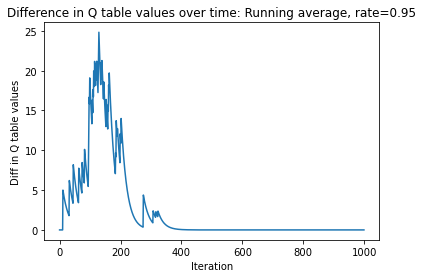

diff in Q reached for epsilon value of 0.5 below 0.01 at iteration 430 for SARSA(lambda)


Q: initial
      up  down  left  right
s0  -1.0   0.0  -1.0    0.0
s1  -1.0   0.0   0.0    0.0
s2  -1.0   0.0   0.0   -1.0
s3   0.0   0.0  -1.0    0.0
s4   0.0   0.0   0.0    0.0
s5   0.0   0.0   0.0   -1.0
s6   0.0   0.0  -1.0    0.0
s7   0.0   0.0   0.0    0.0
s8   0.0   0.0   0.0    0.0
s9   0.0  -1.0  -1.0    0.0
s10  0.0  -1.0   0.0    0.0
s11  0.0  -1.0   0.0   -1.0

Final Q table

         up   down   left  right
s0    -1.00   72.9  -1.00   72.9
s1    -1.00   81.0  65.61   81.0
s2    -1.00   90.0  72.90   -1.0
s3    65.61    0.0  -1.00   81.0
s4    72.90   90.0  72.90   90.0
s5    81.00  100.0  81.00   -1.0
s6    72.90   72.9  -1.00   90.0
s7    81.00   81.0  81.00  100.0
s8     0.00    0.0   0.00    0.0
s9    81.00   -1.0  -1.00   81.0
s10   90.00   -1.0  72.90   90.0
s11  100.00   -1.0  81.00   -1.0

Final visit count table

     up  down  left  right
s0   -1    31    -1     14
s1   -1  

In [7]:
#----------------------------
# Algorithm for SARSA(lambda)
#----------------------------

import numpy as np
import pandas as pd
import random 
import argparse, sys
import matplotlib.pyplot as plt

#--------------------
# config (more config below : search for "modify" 
#
# - for colab, etc, use the "notebook" mode
#--------------------

# mode="console"
mode="notebook" 

#--------------------
# console mode: process command line arguments
#--------------------
def parse_args():

  cmd = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
  cmd.add_argument('--alpha', type=float, default="1.0", help="mixing rate")
  cmd.add_argument('--gamma', type=float, default="0.9", help="discount rate")
  cmd.add_argument('--epsilon', type=float, default="0.5", help="discount rate")
  cmd.add_argument('--num_iter', type=int, default="300", help="number of iterations to run")
  cmd.add_argument('--run_avg_rate', type=float, default="0.95", help="number of iterations to run")
  cmd.add_argument('--display_flag', type=str, default="True", help="display Q table after each iteration?")

  return cmd.parse_args()

#--------------------
# notebook mode: process command line arguments
#--------------------
class argclass:

  def __init__(self):

    self.alpha = 1.0
    self.gamma = 0.9
    self.epsilon = 0.5
    self.num_iter = 1000
    self.run_avg_rate = 0.95
    self.display_flag = "True"

#--------------------
# select mode 
#--------------------
if (mode=="console"):

  args = parse_args()

elif (mode=="notebook"):

  args = argclass()

else:

  print("Invalid mode: check the config")
  exit()

#--------------------
# find sum of abs difference in the two table values
#--------------------
def df_diff(df1, df2):

  d = df1-df2
  return d.abs().to_numpy().sum() 

#----------------------------------------------------------------------------
#
# Environment set up 
#
#----------------------------------------------------------------------------

#--------------------
# state index 
#--------------------
s_index = ["s0", "s1", "s2", "s3", "s4", "s5", "s6","s7","s8","s9","s10","s11"] 

#--------------------
# state transition table 
#--------------------
delta = pd.DataFrame(
	{ 
	  "up"   : pd.Series(np.array([-1,-1, -1, 0, 1, 2, 3, 4, 8, 6, 7, 8]),index=s_index),
	  "down" : pd.Series(np.array([ 3, 4, 5,6,7,8,9,10,8,-1,-1,-1]),index=s_index),
	  "left" : pd.Series(np.array([-1, 0, 1,-1, 3, 4, -1,6,8,-1,9,10]),index=s_index),
	  "right": pd.Series(np.array([ 1, 2, -1, 4, 5,-1, 7, 8, 8, 10, 11, -1]),index=s_index)
	}
)

#--------------------
# reward table 
#--------------------
reward = pd.DataFrame(
	{ 
	  "up"   : pd.Series(np.array([-1, -1,  -1,  0,  0,0,0,0,0,0,0,100]),index=s_index),
	  "down" : pd.Series(np.array([ 0,  0,  0, 0, 0, 100,0,0,0,-1,-1,-1]),index=s_index),
	  "left" : pd.Series(np.array([-1,  0,  0, -1,  0,  0,-1,0,0,-1,0,0]),index=s_index),
	  "right": pd.Series(np.array([ 0,0,  -1,  0,  0, -1,0,100,0,0,0,-1]),index=s_index)
	}
)

print("\n\nDelta")
print(delta)

print("\n\nReward")
print(reward)

#--------------------
# goal state 
#--------------------
goal = 8

#----------------------------------------------------------------------------
#
# Main algorithm 
#
#----------------------------------------------------------------------------
s_next = 0 
a_next = 0 

def qlearn_lambda(): 
  # extract number of states
  num_states = len(s_index)
  num_actions = 4
  
  # set up (s,a) visit count
  visits = (delta>=0).astype(int)-1
  
  run_avg = 0
  sm_del = 0 #initializing small delta to 0
  #--------------------
  # (1) Initialize Q table to zeros (-1 for invalid actions)
  #
  # - Reuse delta table to filter out invalid moves and set others to zero
  #--------------------
 
  Q=(delta>=0).astype(float)-1 

  # initializing eligibility trace matrix to zero 
  E=(delta>=0).astype(float)-1  

  old_Q = Q.copy(deep=True) 
  
  print("\n\nQ: initial")
  print(Q)
  
  #--------------------
  # (2) Main loop
  #--------------------
  
  d = np.zeros(args.num_iter)
  
  for n in range(args.num_iter):
    
    #----------
    # 1. s : randomly select state  
    #----------
    E = E*0

    s = random.randint(0,num_states-1)
  
    while (s==goal): # avoid goal state
      s = random.randint(0,num_states-1)
      
    #----------
    # 2. a : choose action (epsilon greedy policy)
    #----------
  
    if (random.random() < (1-args.epsilon)):
  
      # greedy action:
      a = Q.iloc[s,:].argmax()
  
    else:
  
      # random action
      a = random.randint(0,num_actions-1)
  
      while (delta.iloc[s,a]==-1): # avoid invalid action
        a = random.randint(0,num_actions-1)
  
    #----------
    # 3. train
    #----------
    visits.iloc[s,a] = visits.iloc[s,a]+1

    alpha = args.alpha
    gamma = args.gamma

    # 3.1 find next state from (s,a)
  
    s_next = delta.iloc[s,a]

    #--------------------------------------
    # update to next action based on s_next
    #--------------------------------------
    a_next = Q.iloc[s_next,:].argmax()




  

    #--------------------
    # update small delta
    #-------------------- 
    sm_del = reward.iloc[s,a] + gamma*Q.iloc[s_next,a_next] - Q.iloc[s,a]  
    E.iloc[s,a] = 1  

    # 3.2 update Q
  
    # Equation is: Q(s,a) = (1-alpha) x Q(s,a) + alpha*( r(s,a) + gamma * Q(s',a') )
    Q.iloc[s,a] =  Q.iloc[s,a] + alpha*sm_del*E.iloc[s,a]
    E.iloc[s,a] = alpha * gamma * E.iloc[s,a]

  
  
    # 3.3 compute running average of the sum of Q(n) minus Q(n-1)
  
    d[n] = args.run_avg_rate * run_avg + (1-args.run_avg_rate) * df_diff(Q,old_Q)
    run_avg = d[n]
    old_Q = Q.copy(deep=True)
    
   


    # 3.3 print current Q and running average of Q diff.
  
    if (args.display_flag == "True"):
  
      print("\nQ : iter="+str(n))
      print(Q)
      print("diff = "+str(d[n]))

    if (n>50  and run_avg < 0.01):
 
        break

  #--------------------
  # (3) Print final Q table  and (s,a) visit count table
  #--------------------
  print("\nFinal Q table\n")
  print(Q)
  
  print("\nFinal visit count table\n")
  print(visits)
  
  #--------------------
  # (4) Plot diff Q(n), Q(n-1) running average
  #--------------------
  plt.title("Difference in Q table values over time: Running average, rate="+str(args.run_avg_rate))
  plt.xlabel("Iteration")
  plt.ylabel("Diff in Q table values")
  plt.plot(d)
  plt.show()


  print("diff in Q reached for epsilon value of",str(args.epsilon),"below 0.01 at iteration",str(n),"for SARSA(lambda)")
  return n

#-- end of qlearn_lambda() function def

args.display_flag = "False"  # Set this to "True" to see the changing Q table over time.
args.epsilon = 0.5
qlearn_lambda()
qlearn_n()
